In [1]:
import pandas as pd
import time
from pynvml import *

pos_df = pd.read_csv(r"C:\Users\ASUS\Downloads\yelp_4_and_above")
print(len(pos_df))
# print(pos_df.head(1))
# print(pos_df.columns)

neg_df = pd.read_csv(r"C:\Users\ASUS\Downloads\yelp_2_and_below")
print(len(neg_df))
# print(neg_df.head(1))
print(neg_df.columns)



yelp_df = pd.concat([pos_df,neg_df])
yelp_df['sentiment'] = yelp_df['stars'].apply(lambda x: 1 if x >= 4 else 0)
print(yelp_df["stars"].value_counts())
print(yelp_df["sentiment"].value_counts())

5000
5000
Index(['Unnamed: 0', 'review_id', 'user_id', 'business_id', 'stars', 'useful',
       'funny', 'cool', 'text', 'date'],
      dtype='object')
stars
5.0    3185
1.0    2886
2.0    2114
4.0    1815
Name: count, dtype: int64
sentiment
1    5000
0    5000
Name: count, dtype: int64


In [2]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(yelp_df, test_size=0.2, random_state=42, stratify=yelp_df["sentiment"])

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")

Train size: 8000
Validation size: 2000


In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
# from datasets import load_dataset
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import re
import copy

train_texts = train_df["text"]
train_labels = train_df["sentiment"]
val_texts = val_df["text"]
val_labels = val_df["sentiment"]

def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text.split()

# def tokenize(text, max_len=300):
#     text = text.lower()
#     text = re.sub(r"[^a-z0-9\s]", "", text)
#     return text.split()[:max_len]

counter = Counter()
for text in train_texts:
    counter.update(tokenize(text))
print(f"counterlen: {len(counter)}")
vocab_size = 20000
vocab = {word: idx + 2 for idx, (word, _) in enumerate(counter.most_common(vocab_size))}
vocab["<pad>"] = 0
vocab["<unk>"] = 1

def numericalize(tokens):
    return [vocab.get(token, vocab["<unk>"]) for token in tokens]

class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(numericalize(tokenize(t))) for t in texts]
        self.labels = torch.tensor(labels.tolist())
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

def collate_batch(batch):
    texts, labels = zip(*batch)
    texts_padded = pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    return texts_padded, torch.tensor(labels)

train_data = IMDBDataset(train_texts, train_labels)
val_data = IMDBDataset(val_texts, val_labels)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_batch)


counterlen: 26450


# Test dataset IMDB

In [57]:
IMDB_df = pd.read_csv(r"C:\Users\ASUS\Downloads\SC4001 Neural Network project\IMDB Dataset.csv")
print(len(IMDB_df))
print(IMDB_df.head())
IMDB_df["sentiment"] = IMDB_df["sentiment"].apply(lambda x: 1 if x == "positive" else 0)
test_texts = IMDB_df["review"]
test_labels = IMDB_df["sentiment"]
IMDB_data = IMDBDataset(test_texts, test_labels)
test_loader = DataLoader(IMDB_data, batch_size=32, shuffle=False, collate_fn=collate_batch)

50000
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
from torchtext.vocab import GloVe
glove = GloVe(name="6B", dim=100)
embedding_dim = glove.dim

# Create embedding matrix
embedding_matrix = torch.zeros(len(vocab), embedding_dim)
for word, idx in vocab.items():
    if word in glove.stoi:
        embedding_matrix[idx] = glove[word]
    else:
        embedding_matrix[idx] = torch.randn(embedding_dim) * 0.05  # random init for OOV words

In [29]:
import subprocess

def get_power_usage_watts():
    try:
        # Query power.draw in watts
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=power.draw", "--format=csv,noheader,nounits"]
        )
        return float(result.strip())
    except Exception as e:
        print("Error reading GPU power:", e)
        return 0.0
print(get_power_usage_watts())

7.29


# Preparing training code

In [30]:
from sklearn.metrics import accuracy_score, f1_score
from pynvml import *
import time

import subprocess

def get_power_usage_watts():
    try:
        # Query power.draw in watts
        result = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=power.draw", "--format=csv,noheader,nounits"]
        )
        return float(result.strip())
    except Exception as e:
        print("Error reading GPU power:", e)
        return 0.0
# nvmlInit()
# handle = nvmlDeviceGetHandleByIndex(0)

# def get_power_usage_watts():
#     return nvmlDeviceGetPowerUsage(handle) / 1000.0

# def train_epoch(model, dataloader, optimizer, criterion):
#     model.train()
#     total_loss = 0.0
#     all_preds, all_labels = [], []

#     for texts, labels in dataloader:
#         texts, labels = texts.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(texts)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item() * labels.size(0)  

#         preds = torch.argmax(outputs, dim=1)
#         all_preds.extend(preds.cpu().tolist())
#         all_labels.extend(labels.cpu().tolist())

#     avg_loss = total_loss / len(dataloader.dataset)  
#     accuracy = accuracy_score(all_labels, all_preds)

#     return avg_loss, accuracy

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    start_time = time.time()
    start_power = get_power_usage_watts()

    for texts, labels in dataloader:
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total

    end_time = time.time()
    end_power = get_power_usage_watts()

    elapsed_time = end_time - start_time
    avg_power = (start_power + end_power) / 2  # rough average
    energy_joules = avg_power * elapsed_time

    return avg_loss, accuracy, energy_joules

# def evaluate(model, dataloader, criterion):
#     model.eval()
#     preds, labels_all = [], []
#     total_loss = 0.0
#     total_samples = 0

#     with torch.no_grad():
#         for texts, labels in dataloader:
#             texts, labels = texts.to(device), labels.to(device)
#             outputs = model(texts)

#             loss = criterion(outputs, labels)
#             batch_size = labels.size(0)
#             total_loss += loss.item() * batch_size
#             total_samples += batch_size

#             predictions = torch.argmax(outputs, dim=1)
#             preds.extend(predictions.cpu().tolist())
#             labels_all.extend(labels.cpu().tolist())

#     avg_loss = total_loss / total_samples
#     acc = accuracy_score(labels_all, preds)
#     f1 = f1_score(labels_all, preds) 

#     return avg_loss, acc, f1

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)

            loss = criterion(outputs, labels)
            batch_size = labels.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds).cpu()
    all_labels = torch.cat(all_labels).cpu()

    avg_loss = total_loss / total_samples
    acc = (all_preds == all_labels).float().mean().item()
    f1 = f1_score(all_labels.numpy(), all_preds.numpy())

    return avg_loss, acc, f1

In [ ]:
class biLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, method="last"):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<pad>"])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.3)
        self.method = method  
        
    def forward(self, text):
        embedded = self.embedding(text)  
        output, (hidden, _) = self.lstm(embedded)

        if self.method == "last":
            hidden_fw = hidden[-2, :, :]  
            hidden_bw = hidden[-1, :, :]  
            hidden_cat = torch.cat((hidden_fw, hidden_bw), dim=1)  
            
        elif self.method == "avg":
            hidden_cat = torch.mean(output, dim=1)  

        hidden_cat = self.dropout(hidden_cat)
        return self.fc(hidden_cat)

model = biLSTM(vocab_size=embedding_matrix.shape[0], embed_dim=embedding_matrix.shape[1], hidden_dim=128, output_dim=2, method='avg').to(device)
model.embedding.weight.data.copy_(embedding_matrix)
model.embedding.weight.requires_grad = False
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

best_acc = 0.0
best_model_state = None
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_f1s = []

patience = 5 
best_val_loss = float('inf')
epochs_no_improve = 0

total_energy_usage = 0.0

for epoch in range(50):
    train_loss, train_acc, energy_used = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)
    total_energy_usage += energy_used
    
    print(f"Epoch {epoch+1}: train loss={train_loss:.4f},val loss={val_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, val_f1={val_f1:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"New best accuracy: {best_acc:.4f} at epoch {epoch+1}, saving model.")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement in val loss for {epochs_no_improve} epochs")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break
print(f"total energy usage: {total_energy_usage}")

Epoch 1: train loss=0.6221,val loss=0.5883, train_acc=0.6504, val_acc=0.7025, val_f1=0.7590
New best accuracy: 0.7025 at epoch 1, saving model.
Epoch 2: train loss=0.5349,val loss=0.5048, train_acc=0.7676, val_acc=0.7505, val_f1=0.7861
New best accuracy: 0.7505 at epoch 2, saving model.
Epoch 3: train loss=0.4695,val loss=0.4334, train_acc=0.8091, val_acc=0.8365, val_f1=0.8359
New best accuracy: 0.8365 at epoch 3, saving model.
Epoch 4: train loss=0.4189,val loss=0.3925, train_acc=0.8373, val_acc=0.8560, val_f1=0.8573
New best accuracy: 0.8560 at epoch 4, saving model.
Epoch 5: train loss=0.3800,val loss=0.4043, train_acc=0.8581, val_acc=0.8565, val_f1=0.8493
New best accuracy: 0.8565 at epoch 5, saving model.
No improvement in val loss for 1 epochs
Epoch 6: train loss=0.3436,val loss=0.3627, train_acc=0.8756, val_acc=0.8705, val_f1=0.8674
New best accuracy: 0.8705 at epoch 6, saving model.
Epoch 7: train loss=0.3263,val loss=0.3367, train_acc=0.8786, val_acc=0.8785, val_f1=0.8773
New 

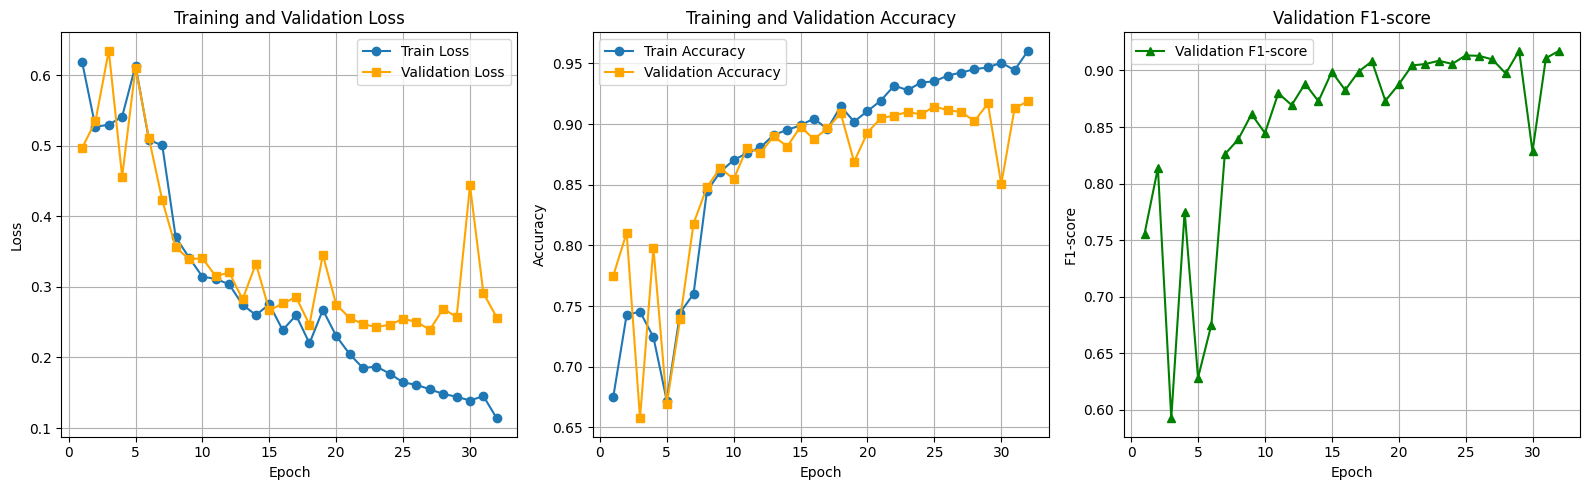

In [47]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='s', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs, val_f1s, label='Validation F1-score', marker='^', color='green')
plt.title('Validation F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Processed 32 samples...
Processed 3,232 samples...
Processed 6,432 samples...
Processed 9,632 samples...
Processed 12,832 samples...
Processed 16,032 samples...
Processed 19,232 samples...
Processed 22,432 samples...
Processed 25,632 samples...
Processed 28,832 samples...
Processed 32,032 samples...
Processed 35,232 samples...
Processed 38,432 samples...
Processed 41,632 samples...
Processed 44,832 samples...
Processed 48,032 samples...
Test Accuracy: 0.7833
Test F1: 0.782884617542513
Confusion Matrix:
 [[20676  4324]
 [ 6511 18489]]


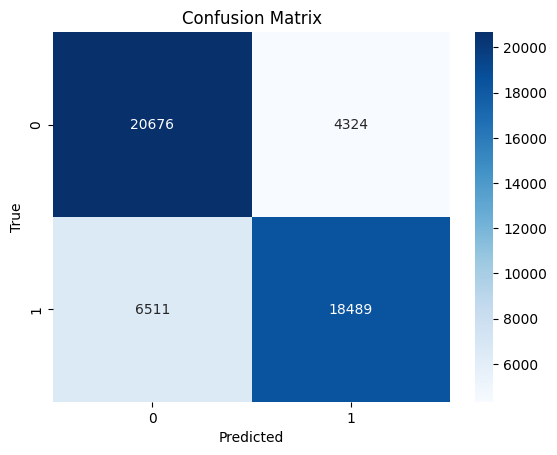

In [50]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def test(model, dataloader, criterion, return_preds=False):
    model.eval()
    total_loss, total_samples = 0.0, 0
    all_preds, all_labels = [], []

    with torch.inference_mode():
        for i, (texts, labels) in enumerate(dataloader):
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

            preds = torch.argmax(outputs, dim=1).detach().cpu()
            all_preds.append(preds)
            all_labels.append(labels.cpu())

            if i % 100 == 0:
                print(f"Processed {total_samples:,} samples...")

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    avg_loss = total_loss / total_samples
    acc = np.mean(all_preds == all_labels)
    f1 = f1_score(all_labels, all_preds, average="weighted")

    cm = confusion_matrix(all_labels, all_preds) if return_preds else None
    return (avg_loss, acc, f1, cm, all_labels, all_preds) if return_preds else (avg_loss, acc, f1)

# def test(model, dataloader, criterion, return_preds=False):
#     model.eval()
#     total_loss = 0.0
#     total_samples = 0
#     all_preds, all_labels = [], []

#     with torch.inference_mode():  # Faster than no_grad
#         for texts, labels in dataloader:
#             texts = texts.to(device, non_blocking=True)
#             labels = labels.to(device, non_blocking=True)
            
#             outputs = model(texts)
#             loss = criterion(outputs, labels)

#             total_loss += loss.item() * labels.size(0)
#             total_samples += labels.size(0)

#             preds = torch.argmax(outputs, dim=1)

#             # Convert to CPU NumPy immediately to avoid GPU sync later
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#             if total_samples % 100 < labels.size(0):
#                 print(f"Processed {total_samples:,} samples...")


#     avg_loss = total_loss / total_samples
#     acc = np.mean(np.array(all_preds) == np.array(all_labels))
#     f1 = f1_score(all_labels, all_preds, average="weighted")

#     cm = confusion_matrix(all_labels, all_preds) if return_preds else None

#     if return_preds:
#         return avg_loss, acc, f1, cm, np.array(all_labels), np.array(all_preds)
#     else:
#         return avg_loss, acc, f1

test_loss, test_acc, test_f1, cm, labels, preds = test(model, test_loader, criterion, return_preds=True)
print("Test Accuracy:", test_acc)
print("Test F1:", test_f1)
print("Confusion Matrix:\n", cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [58]:
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd

def test_worst(model, dataloader, criterion, return_preds=False, text_dataset=None, label_names=None):
    model.eval()
    total_loss, total_samples = 0.0, 0
    all_preds, all_labels, all_probs, all_texts = [], [], [], []

    with torch.inference_mode():
        for i, (texts, labels) in enumerate(dataloader):
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

            probs = F.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

            # store original texts if provided
            if text_dataset is not None:
                all_texts.extend(text_dataset[i * dataloader.batch_size : i * dataloader.batch_size + len(labels)])

            if i % 100 == 0:
                print(f"Processed {total_samples:,} samples...")

    # Combine all batches
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_probs = torch.cat(all_probs)

    avg_loss = total_loss / total_samples
    acc = (all_preds == all_labels).float().mean().item()
    f1 = f1_score(all_labels, all_preds, average="weighted")

    cm = confusion_matrix(all_labels, all_preds) if return_preds else None

    # === Build full misclassification DataFrame ===
    wrong_mask = all_preds != all_labels
    wrong_indices = torch.where(wrong_mask)[0]

    rows = []
    for idx in wrong_indices:
        true_label = int(all_labels[idx])
        pred_label = int(all_preds[idx])
        pred_conf = float(all_probs[idx, pred_label])
        true_conf = float(all_probs[idx, true_label])
        text = all_texts[idx] if text_dataset is not None else None

        rows.append({
            "index": int(idx),
            "true_label": label_names[true_label] if label_names else true_label,
            "pred_label": label_names[pred_label] if label_names else pred_label,
            "true_conf": true_conf,
            "pred_conf": pred_conf,
            "text": text
        })

    df_wrong = pd.DataFrame(rows)

    # Sort within each class by predicted confidence (most confidently wrong first)
    df_sorted = df_wrong.sort_values(["true_label", "pred_conf"], ascending=[True, False]).reset_index(drop=True)

    return {
        "avg_loss": avg_loss,
        "acc": acc,
        "f1": f1,
        "confusion_matrix": cm,
        "labels": all_labels.numpy(),
        "preds": all_preds.numpy(),
        "misclassified": df_sorted
    }


label_names = ["Negative", "Positive"]

results = test_worst(
    model, 
    test_loader, 
    criterion, 
    return_preds=True, 
    text_dataset=test_texts, 
    label_names=label_names
)

# Access metrics
print("Accuracy:", results["acc"])
print("F1 Score:", results["f1"])

# Access full sorted misclassified samples
df_wrong = results["misclassified"]
print(df_wrong.head())

# Example: show worst predictions for positive class
df_wrong[df_wrong["true_label"] == "Positive"].head(10)


Processed 32 samples...
Processed 3,232 samples...
Processed 6,432 samples...
Processed 9,632 samples...
Processed 12,832 samples...
Processed 16,032 samples...
Processed 19,232 samples...
Processed 22,432 samples...
Processed 25,632 samples...
Processed 28,832 samples...
Processed 32,032 samples...
Processed 35,232 samples...
Processed 38,432 samples...
Processed 41,632 samples...
Processed 44,832 samples...
Processed 48,032 samples...
Accuracy: 0.7834200263023376
F1 Score: 0.7830048475651014
   index true_label pred_label  true_conf  pred_conf  \
0  32064   Negative   Positive   0.000008   0.999992   
1  37725   Negative   Positive   0.000018   0.999982   
2  37200   Negative   Positive   0.000029   0.999971   
3  10245   Negative   Positive   0.000038   0.999962   
4  49200   Negative   Positive   0.000045   0.999954   

                                                text  
0  Brilliant acting, excellent plot, wonderful sp...  
1  Fantastic Mr. Fox is a comedy based on the cla...  

,index,true_label,pred_label,true_conf,pred_conf,text
4321,49747,Positive,Negative,0.000039,0.999961,Totally disgusting and cheap bawdy humor. I lo...
4322,22308,Positive,Negative,0.000045,0.999954,Most horror movies are in fact horrible movies...
4323,41994,Positive,Negative,0.000052,0.999948,"Stupid, Stupid, Stupid. I think that Angelina ..."
4324,42636,Positive,Negative,0.000119,0.999881,"Most movies about, or set in, New Orleans, tur..."
4325,2087,Positive,Negative,0.000139,0.999861,most of the bad reviews on this website blame ...
4326,9651,Positive,Negative,0.000140,0.999860,Niagra Niagra was certainly not the best movie...
4327,31360,Positive,Negative,0.000152,0.999848,Zombie Bloodbath is a movie made by zombie fan...
4328,25434,Positive,Negative,0.000152,0.999848,Do-It-Yourself indie horror auteur Todd Sheets...
4329,29509,Positive,Negative,0.000166,0.999834,"This movie catches a lot of flak, but this is ..."
4330,1016,Positive,Negative,0.000176,0.999824,Jackass Number Two is easily the most hilariou...


In [59]:
# df_wrong = results["misclassified"]
# print(df_wrong.head())

# Example: show worst predictions for positive class
for text in df_wrong[df_wrong["true_label"] == "Positive"].head(5)["text"]:
    print(text)
    print()
for text in df_wrong[df_wrong["true_label"] == "Negative"].head(5)["text"]:
    print(text)
    print()

Totally disgusting and cheap bawdy humor. I loved it!!! It is the most disgusting and totally horribly acted film, except for Nicolas Read, who plays an un-dead Court Jester, to comic brilliance. But being that as it may, I laughed so many times and I have to hand it to the film makers, it wasn't pretentious or ordinary in any way. Raping, fighting, zombies vomitting on their rape victims. What other movie has this? Not for the quesy, but with a pizza, a bong, and a six pack of beer, you got it made, if you have a cast iron stomach and a juvenille sense of humor like myself.

Most horror movies are in fact horrible movies. They get to be same ol'-same ol'. Same ol' pack every minute with some cheap thrill (usually 'splatter') and nowadays they can pack every second with gaudy special effects. One of the goals of a really good horror flick is to suspend the sense of disbelief of the audience. For instance, I saw both of the recent Mummy movies and nearly got dizzy viewing ridiculous spe

In [60]:
top_pos = df_wrong[df_wrong["true_label"] == "Positive"].head(5)
top_neg = df_wrong[df_wrong["true_label"] == "Negative"].head(5)

# Combine them
top_combined = pd.concat([top_pos, top_neg])

# Save to CSV
top_combined.to_csv("top_misclassified_examples.csv", index=False)

# SimpleRNN

In [37]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size,embed_dim, hidden_size, output_size, method="last", num_layers=1, dropout=0):
        super(SimpleRNN, self).__init__()
        # self.embedding_transform = nn.Linear(embed_dim, embed_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.method = method

    def forward(self, x):
        # embeds = self.embedding_transform(x)
        embeds = self.embedding(x)
        out, _ = self.rnn(embeds)
        if self.method == "last":
            out = self.dropout(self.fc(out[:, -1, :]))
        elif self.method == "avg":
            out = self.dropout(self.fc(out.mean(dim=1)))
        elif self.method == "max":
            out, _ = out.max(dim=1)
            out = self.dropout(self.fc(out))
        return out

model = SimpleRNN(vocab_size=len(vocab), embed_dim=100, hidden_size=128, output_size=2, method="avg").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_acc = 0.0
best_model_state = None
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_f1s = []

patience = 5 
best_val_loss = float('inf')
epochs_no_improve = 0

total_energy_usage = 0.0

for epoch in range(50):
    train_loss, train_acc, energy_used = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)
    total_energy_usage += energy_used
    
    print(f"Epoch {epoch+1}: train loss={train_loss:.4f},val loss={val_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, val_f1={val_f1:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"New best accuracy: {best_acc:.4f} at epoch {epoch+1}, saving model.")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement in val loss for {epochs_no_improve} epochs")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break
print(f"total energy usage: {total_energy_usage}")

Epoch 1: train loss=0.6572,val loss=0.5791, train_acc=0.6044, val_acc=0.7510, val_f1=0.7690
New best accuracy: 0.7510 at epoch 1, saving model.
Epoch 2: train loss=0.5570,val loss=0.6325, train_acc=0.7680, val_acc=0.6260, val_f1=0.7114
No improvement in val loss for 1 epochs
Epoch 3: train loss=0.6454,val loss=0.6829, train_acc=0.6040, val_acc=0.5240, val_f1=0.2551
No improvement in val loss for 2 epochs
Epoch 4: train loss=0.6375,val loss=0.5867, train_acc=0.6279, val_acc=0.6910, val_f1=0.7253
No improvement in val loss for 3 epochs
Epoch 5: train loss=0.4893,val loss=0.4561, train_acc=0.7897, val_acc=0.7770, val_f1=0.8046
New best accuracy: 0.7770 at epoch 5, saving model.
Epoch 6: train loss=0.3465,val loss=0.3640, train_acc=0.8849, val_acc=0.8725, val_f1=0.8733
New best accuracy: 0.8725 at epoch 6, saving model.
Epoch 7: train loss=0.4987,val loss=0.3857, train_acc=0.8566, val_acc=0.8690, val_f1=0.8685
No improvement in val loss for 1 epochs
Epoch 8: train loss=0.2720,val loss=0.37

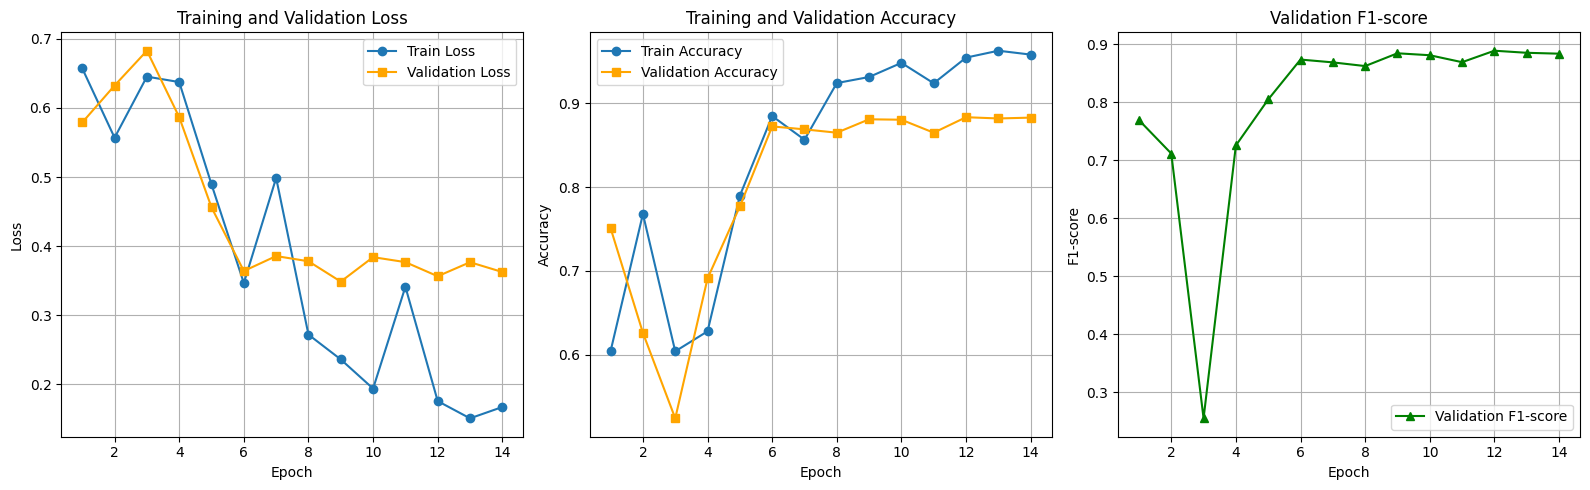

In [38]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(16, 5))

# 1️⃣ Train + Val Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 2️⃣ Train + Val Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='s', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 3️⃣ Validation F1-score
plt.subplot(1, 3, 3)
plt.plot(epochs, val_f1s, label='Validation F1-score', marker='^', color='green')
plt.title('Validation F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Test Accuracy: 0.7278
Test F1: 0.7265190058343668
Confusion Matrix:
 [[16484  8516]
 [ 5094 19906]]


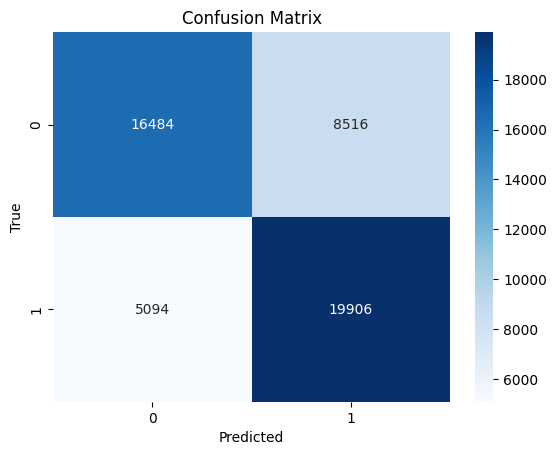

In [39]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def test(model, dataloader, criterion, return_preds=False):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_preds, all_labels = [], []

    with torch.inference_mode():  # Faster than no_grad
        for texts, labels in dataloader:
            texts = texts.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            outputs = model(texts)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

            preds = torch.argmax(outputs, dim=1)

            # Convert to CPU NumPy immediately to avoid GPU sync later
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / total_samples
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds, average="weighted")

    cm = confusion_matrix(all_labels, all_preds) if return_preds else None

    if return_preds:
        return avg_loss, acc, f1, cm, np.array(all_labels), np.array(all_preds)
    else:
        return avg_loss, acc, f1

test_loss, test_acc, test_f1, cm, labels, preds = test(model, test_loader, criterion, return_preds=True)
print("Test Accuracy:", test_acc)
print("Test F1:", test_f1)
print("Confusion Matrix:\n", cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# GLOVE embeddings

In [40]:
from torchtext.vocab import GloVe
glove = GloVe(name="6B", dim=100)
embedding_dim = glove.dim

# Create embedding matrix
embedding_matrix = torch.zeros(len(vocab), embedding_dim)
for word, idx in vocab.items():
    if word in glove.stoi:
        embedding_matrix[idx] = glove[word]
    else:
        embedding_matrix[idx] = torch.randn(embedding_dim) * 0.05  # random init for OOV words

c:\Users\ASUS\anaconda3\envs\SC4001\Lib\site-packages\torchtext\vocab.py:432: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.itos, self.stoi, self.vectors, self.dim = to

In [ ]:
import copy

model = biLSTM(vocab_size=len(vocab), embed_dim=100, hidden_dim=128, output_dim=2).to(device)
model.embedding.weight.data.copy_(embedding_matrix)
model.embedding.weight.requires_grad = False
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_acc = 0.0
best_model_state = None
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_f1s = []

patience = 5 
best_val_loss = float('inf')
epochs_no_improve = 0

total_energy_usage = 0.0

for epoch in range(50):
    train_loss, train_acc,energy_used = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)
    total_energy_usage += energy_used
    
    print(f"Epoch {epoch+1}: train loss={train_loss:.4f},val loss={val_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, val_f1={val_f1:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"New best accuracy: {best_acc:.4f} at epoch {epoch+1}, saving model.")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement in val loss for {epochs_no_improve} epochs")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

Epoch 1: loss=0.5178, acc=0.8645, f1=0.8704
New best accuracy: 0.8645 at epoch 1, saving model.
Epoch 2: loss=0.2904, acc=0.9005, f1=0.8959
New best accuracy: 0.9005 at epoch 2, saving model.
Epoch 3: loss=0.2167, acc=0.9125, f1=0.9118
New best accuracy: 0.9125 at epoch 3, saving model.
Epoch 4: loss=0.1758, acc=0.9155, f1=0.9143
New best accuracy: 0.9155 at epoch 4, saving model.
Epoch 5: loss=0.1451, acc=0.9205, f1=0.9212
New best accuracy: 0.9205 at epoch 5, saving model.
Epoch 6: loss=0.1137, acc=0.9185, f1=0.9176
Epoch 7: loss=0.0840, acc=0.9130, f1=0.9163
Epoch 8: loss=0.0822, acc=0.9200, f1=0.9194
Epoch 9: loss=0.0569, acc=0.9210, f1=0.9219
New best accuracy: 0.9210 at epoch 9, saving model.
Epoch 10: loss=0.0352, acc=0.9145, f1=0.9156
Epoch 11: loss=0.0441, acc=0.9140, f1=0.9121
Epoch 12: loss=0.0390, acc=0.9165, f1=0.9160
Epoch 13: loss=0.0329, acc=0.9180, f1=0.9171
Epoch 14: loss=0.0170, acc=0.9125, f1=0.9138
Epoch 15: loss=0.0235, acc=0.9150, f1=0.9176
Epoch 16: loss=0.0372,

50000
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
# model = biLSTM(vocab_size=len(vocab), embed_dim=100, hidden_dim=128, output_dim=2).to(device)
model = SimpleRNN(vocab_size=len(vocab), embed_dim=100, hidden_size=128, output_size=2, method="avg").to(device)

# model.load_state_dict(torch.load(best_model_state))
model.load_state_dict(best_model_state)
model.eval()
print(evaluate(model, test_loader))

(0.73552, 0.7485549132947977)


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size,
                 num_layers=1, dropout=0, method="last", kernel_sizes=(3,4,5), cnn_channels=100):
        super(CNNLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # --- CNN branch ---
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=cnn_channels, kernel_size=k)
            for k in kernel_sizes
        ])

        # --- LSTM ---
        self.lstm = nn.LSTM(
            input_size=cnn_channels * len(kernel_sizes),
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.method = method

    def forward(self, x):
        """
        x: LongTensor (batch, seq_len)
        returns: logits (batch, output_size)
        """
        # (B, L, E)
        emb = self.embedding(x)
        # prepare for conv1d: (B, E, L)
        emb_t = emb.transpose(1, 2)

        # --- apply multi-kernel CNN ---
        cnn_outs = []
        for conv in self.convs:
            c = F.relu(conv(emb_t))                     # (B, C, L - k + 1)
            c = c.transpose(1, 2)                       # (B, L', C)
            cnn_outs.append(c)

        # To align lengths, pad shorter conv outputs
        min_len = min(out.size(1) for out in cnn_outs)
        cnn_outs = [out[:, :min_len, :] for out in cnn_outs]
        cnn_cat = torch.cat(cnn_outs, dim=2)            # (B, L', C_total)

        # --- feed CNN output into LSTM ---
        lstm_out, _ = self.lstm(cnn_cat)                # (B, L', H)

        # --- pooling method ---
        if self.method == "last":
            out = lstm_out[:, -1, :]                    # (B, H)
        elif self.method == "avg":
            out = lstm_out.mean(dim=1)                  # (B, H)
        elif self.method == "max":
            out, _ = lstm_out.max(dim=1)                # (B, H)
        else:
            raise ValueError(f"Unknown method: {self.method}")

        # --- classification head ---
        out = self.dropout(out)
        out = self.fc(out)                              # (B, output_size)
        return out
    
model = CNNLSTM(vocab_size=len(vocab), embed_dim=100, hidden_size=128, output_size=2, method="max").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_acc = 0.0
best_model_state = None
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_f1s = []

patience = 5 
best_val_loss = float('inf')
epochs_no_improve = 0

nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)  # GPU 0

def get_power_usage_watts():
    return nvmlDeviceGetPowerUsage(handle) / 1000.0

for epoch in range(50):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)
    
    print(f"Epoch {epoch+1}: train loss={train_loss:.4f},val loss={val_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, val_f1={val_f1:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        print(f"New best accuracy: {best_acc:.4f} at epoch {epoch+1}, saving model.")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement in val loss for {epochs_no_improve} epochs")

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch}.")
        break

Epoch 1: train loss=0.4966,val loss=0.3481, train_acc=0.7430, val_acc=0.8535, val_f1=0.8587
New best accuracy: 0.8535 at epoch 1, saving model.
Epoch 2: train loss=0.2276,val loss=0.2928, train_acc=0.9117, val_acc=0.8735, val_f1=0.8809
New best accuracy: 0.8735 at epoch 2, saving model.
Epoch 3: train loss=0.1075,val loss=0.3099, train_acc=0.9635, val_acc=0.8740, val_f1=0.8635
New best accuracy: 0.8740 at epoch 3, saving model.
No improvement in val loss for 1 epochs
Epoch 4: train loss=0.0480,val loss=0.2625, train_acc=0.9859, val_acc=0.9035, val_f1=0.9017
New best accuracy: 0.9035 at epoch 4, saving model.
Epoch 5: train loss=0.0241,val loss=0.3415, train_acc=0.9931, val_acc=0.8945, val_f1=0.8903
No improvement in val loss for 1 epochs
Epoch 6: train loss=0.0075,val loss=0.3453, train_acc=0.9989, val_acc=0.9020, val_f1=0.9021
No improvement in val loss for 2 epochs
Epoch 7: train loss=0.0024,val loss=0.3851, train_acc=0.9999, val_acc=0.9030, val_f1=0.9043
No improvement in val loss f

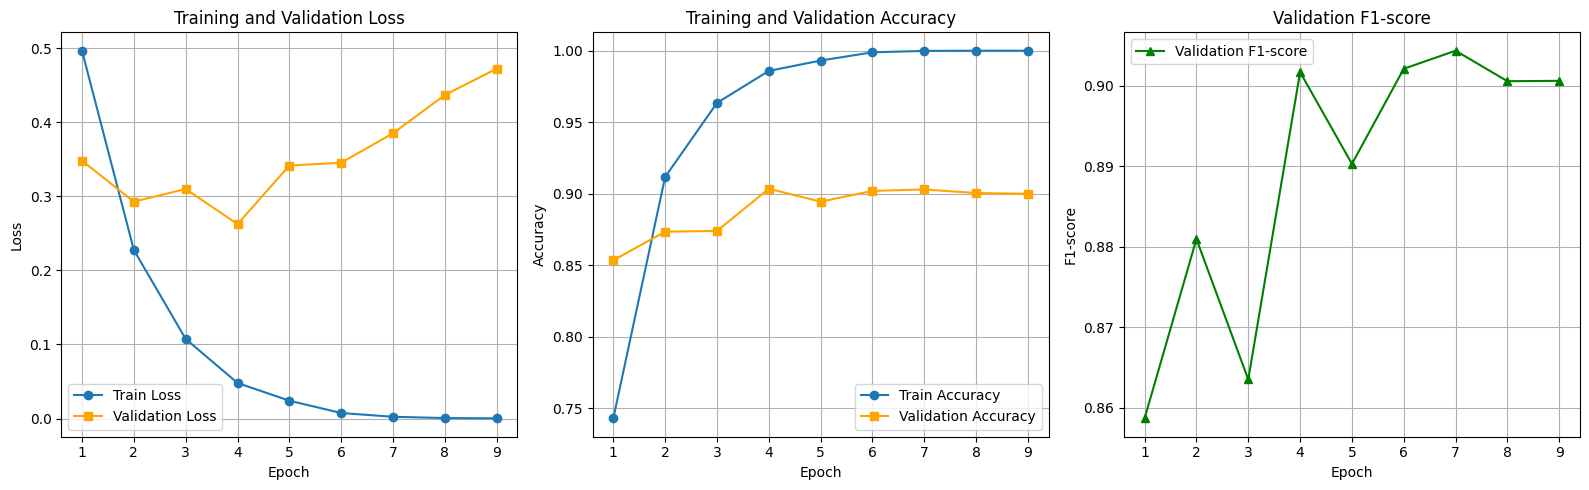

In [18]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='s', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='s', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs, val_f1s, label='Validation F1-score', marker='^', color='green')
plt.title('Validation F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [20]:
# model = biLSTM(vocab_size=len(vocab), embed_dim=100, hidden_dim=128, output_dim=2).to(device)
# model = CNNLSTM(vocab_size=len(vocab), embed_dim=100, hidden_size=128, output_size=2, method="max").to(device)

# model.load_state_dict(torch.load(best_model_state))
# model.load_state_dict(best_model_state)
model.eval()
test_loss, test_acc, test_f1 = evaluate(model, test_loader,criterion)
print(f"Test_acc: {test_acc:.4f}, test_f1: {test_f1:.4f}")

KeyboardInterrupt: 

Test Accuracy: 0.7337
Test F1: 0.7312072998243077
Confusion Matrix:
 [[15935  9065]
 [ 4250 20750]]


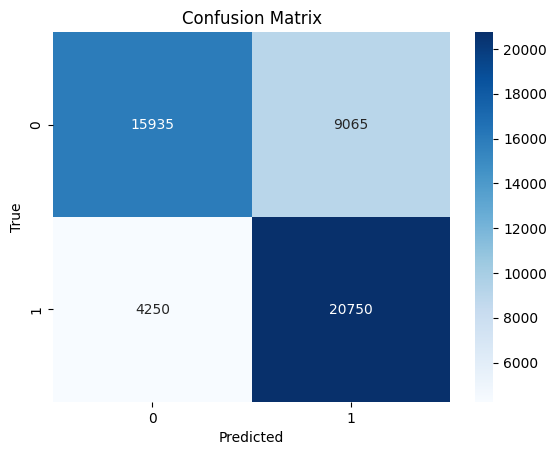

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def test(model, dataloader, criterion, return_preds=False):
    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_preds, all_labels = [], []

    with torch.inference_mode():  # Faster than no_grad
        for texts, labels in dataloader:
            texts = texts.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            outputs = model(texts)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

            preds = torch.argmax(outputs, dim=1)

            # Convert to CPU NumPy immediately to avoid GPU sync later
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / total_samples
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds, average="weighted")

    cm = confusion_matrix(all_labels, all_preds) if return_preds else None

    if return_preds:
        return avg_loss, acc, f1, cm, np.array(all_labels), np.array(all_preds)
    else:
        return avg_loss, acc, f1

test_loss, test_acc, test_f1, cm, labels, preds = test(model, test_loader, criterion, return_preds=True)
print("Test Accuracy:", test_acc)
print("Test F1:", test_f1)
print("Confusion Matrix:\n", cm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
dictionary = pd.read_csv(r"C:\Users\ASUS\Downloads\SC4001 Neural Network project\SC4001-Neural-Network-and-Deep-learning-Project\stanfordSentimentTreebank\dictionary.txt", sep="|", names=["phrase", "phrase_id"])
dictionary['phrase_id'] = dictionary['phrase_id'].astype(int)
print(dictionary.head())

        phrase  phrase_id
0            !          0
1          ! '      22935
2         ! ''      18235
3       ! Alas     179257
4  ! Brilliant      22936


In [36]:
labels = pd.read_csv(r"C:\Users\ASUS\Downloads\SC4001 Neural Network project\SC4001-Neural-Network-and-Deep-learning-Project\stanfordSentimentTreebank\sentiment_labels.txt", sep="|", names=["phrase_id", "sentiment_score"])
labels=labels.iloc[1:]
print(labels.head())
labels['phrase_id'] = labels['phrase_id'].astype(int)
phrase_sentiments = pd.merge(dictionary, labels, on="phrase_id")
print(phrase_sentiments.head())
print(len(phrase_sentiments))

  phrase_id sentiment_score
1         0             0.5
2         1             0.5
3         2         0.44444
4         3             0.5
5         4         0.42708
        phrase  phrase_id sentiment_score
0            !          0             0.5
1          ! '      22935         0.52778
2         ! ''      18235             0.5
3       ! Alas     179257         0.44444
4  ! Brilliant      22936         0.86111
239232


In [38]:
sentences = pd.read_csv(r"C:\Users\ASUS\Downloads\SC4001 Neural Network project\SC4001-Neural-Network-and-Deep-learning-Project\stanfordSentimentTreebank\datasetSentences.txt", sep="\t")

print(len(sentences))
print(sentences.head())

11855
   sentence_index                                           sentence
0               1  The Rock is destined to be the 21st Century 's...
1               2  The gorgeously elaborate continuation of `` Th...
2               3                     Effective but too-tepid biopic
3               4  If you sometimes like to go to the movies to h...
4               5  Emerges as something rare , an issue movie tha...


In [42]:

full_sentence_sentiments = phrase_sentiments[phrase_sentiments['phrase'].isin(sentences['sentence'])]
print(len(full_sentence_sentiments))
def to_binary_label(score):
    if score <= 0.4:
        return 0
    elif score > 0.6:
        return 1
    else:
        return None

full_sentence_sentiments['label'] = full_sentence_sentiments['sentiment_score'].astype(float).apply(to_binary_label)

# Drop rows with neutral labels
binary_labeled_df = full_sentence_sentiments.dropna(subset=['label'])
# print(full_sentence_sentiments.head())
# print(binary_labeled_df.head())
final_df = binary_labeled_df[['phrase', 'label']]

11272


C:\Users\ASUS\AppData\Local\Temp\ipykernel_38120\1937996745.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_sentence_sentiments['label'] = full_sentence_sentiments['sentiment_score'].astype(float).apply(to_binary_label)


In [49]:
# model = SimpleRNN(vocab_size=len(vocab), embed_dim=100, hidden_size=128, output_size=2, method="avg").to(device)
model = CNNLSTM(vocab_size=len(vocab), embed_dim=100, hidden_size=128, output_size=2, method="max").to(device)
# model.load_state_dict(torch.load(best_model_state))
model.load_state_dict(best_model_state)
model.eval()
test_texts = final_df["phrase"]
test_labels = final_df["label"]
Stanford_data = IMDBDataset(test_texts, test_labels)
test_loader = DataLoader(Stanford_data, batch_size=32, shuffle=True, collate_fn=collate_batch)
print(evaluate(model, test_loader))

(0.6406746249041726, 0.6863588567058598)
